By *Felix Marti Perez*

In [84]:
import lenskit
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import basic,Recommender, als, item_knn, user_knn, Predictor
from lenskit import topn
from lenskit.metrics.predict import rmse
import pandas as pd

In [85]:
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['user', 'item', 'rating', 'timestamp'])


In [86]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [87]:
algo_bias = lenskit.algorithms.basic.Bias(damping=5)
#algo.fit(data)


In [88]:
algo_ii = lenskit.algorithms.item_knn.ItemItem(20)
algo_ii = lenskit.algorithms.basic.Fallback(algo_ii, algo_bias)


In [89]:
algo_uu = lenskit.algorithms.user_knn.UserUser(20)
algo_uu = lenskit.algorithms.basic.Fallback(algo_uu, algo_bias)

In [90]:
algo_als = lenskit.algorithms.als.BiasedMF(50)
algo_als = lenskit.algorithms.basic.Fallback(algo_als, algo_bias)

In [91]:
algo_implicit = lenskit.algorithms.als.ImplicitMF(50)
algo_implicit = lenskit.algorithms.basic.Fallback(algo_implicit, algo_bias)

In [92]:
algo_funk = lenskit.algorithms.funksvd.FunkSVD(50)
algo_funk = lenskit.algorithms.basic.Fallback(algo_funk, algo_bias)

In [93]:
def eval(alg_name, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = alg_name
    return recs

In [94]:
all_recs = []
test_data = []
for train, test in xf.partition_users(data[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('Bias', algo_bias, train, test))
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('UserUser', algo_uu, train, test))
    all_recs.append(eval('BiasedMF', algo_als, train, test))
    all_recs.append(eval('ImplicitMF', algo_implicit, train, test))
    all_recs.append(eval('FunkSVD', algo_funk, train, test))

2023-05-09 20:00:52.680812: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 20:00:52.681293: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 20:00:52.771847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 20:00:52.774055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 20:00:52.775819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-09 20:00:52.777466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instru

In [95]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,169,3.982726,3,1,Bias
1,483,3.977600,3,2,Bias
2,408,3.974290,3,3,Bias
3,64,3.967294,3,4,Bias
4,114,3.929001,3,5,Bias


In [96]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,3,323,2
1,3,327,4
2,3,341,1
3,3,348,4
4,3,181,4


In [97]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
Bias      3       100  0.034805
          4       100  0.073214
          7       100  0.299239
          17      100  0.000000
          28      100  0.119059

Algorithm
Bias          0.125365
BiasedMF      0.131403
FunkSVD       0.082347
ImplicitMF    0.387945
ItemItem      0.096077
UserUser      0.063562
Name: ndcg, dtype: float64


<AxesSubplot: xlabel='Algorithm'>

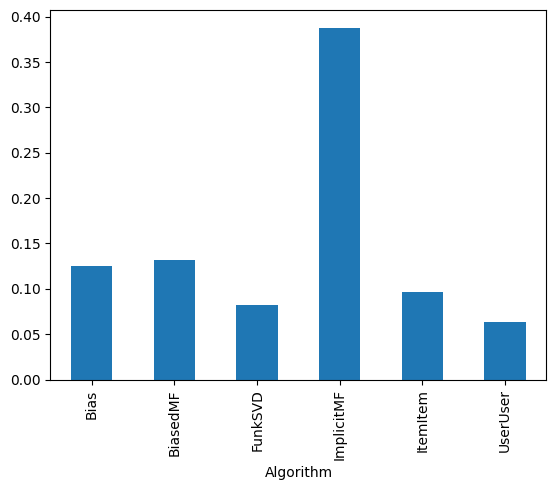

In [98]:
print(results.groupby('Algorithm').ndcg.mean())
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [99]:
algo_bias.fit(data)
algo_ii.fit(data)
algo_uu.fit(data)
algo_als.fit(data)
algo_implicit.fit(data)
algo_funk.fit(data)

In [100]:
predictions_bias = algo_bias.predict_for_user(196, [302])
predictions_ii = algo_ii.predict_for_user(196, [302])
predictions_uu = algo_uu.predict_for_user(196, [302])
predictions_als = algo_als.predict_for_user(196, [302])
predictions_implicit = algo_implicit.predict_for_user(196, [302])
predictions_funk = algo_funk.predict_for_user(196, [302])


In [101]:
print("Bias: ", predictions_bias.values)
print("ItemItem: ", predictions_ii.values)
print("UserUser: ", predictions_uu.values)
print("BiasedMF: ", predictions_als.values)
print("ImplicitMF: ", predictions_implicit.values)
print("FunkSVD: ", predictions_funk.values)

Bias:  [4.16257396]
ItemItem:  [3.80414883]
UserUser:  [4.05530451]
BiasedMF:  [3.88518143]
ImplicitMF:  [0.81603462]
FunkSVD:  [4.18729037]


In [102]:
bias = []
ii = []
uu = []
als = []
implicit = []
funk = []

for i in range(3):
    bias.append(algo_bias.predict_for_user(196, [302]).values[0])
    ii.append(algo_ii.predict_for_user(196, [302]).values[0])
    uu.append(algo_uu.predict_for_user(196, [302]).values[0])
    als.append(algo_als.predict_for_user(196, [302]).values[0])
    implicit.append(algo_implicit.predict_for_user(196, [302]).values[0])
    funk.append(algo_funk.predict_for_user(196, [302]).values[0])

print("Bias: ", bias)    
print("ItemItem: ", ii)
print("UserUser: ", uu)
print("BiasedMF: ", als)
print("ImplicitMF: ", implicit)
print("FunkSVD: ", funk)

Bias:  [4.162573955168441, 4.162573955168441, 4.162573955168441]
ItemItem:  [3.804148828543019, 3.804148828543019, 3.804148828543019]
UserUser:  [4.055304507958933, 4.055304507958933, 4.055304507958933]
BiasedMF:  [3.885181434461094, 3.885181434461094, 3.885181434461094]
ImplicitMF:  [0.8160346188082446, 0.8160346188082446, 0.8160346188082446]
FunkSVD:  [4.187290369037841, 4.187290369037841, 4.187290369037841]


In [103]:
algo_random = lenskit.algorithms.basic.Random()
algo_random.fit(data)
predictions_random = algo_random.recommend(196, 1)
print("Random: ", predictions_random.values)

Random:  [[1534]]
